In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
#import statements

import tensorflow as tf
from tensorflow.keras.layers import  Input, Activation, Flatten, Conv2D, MaxPooling2D,  Dense, BatchNormalization, Dropout
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import shap


In [21]:
'''
Declare all paths which are used to trian and save
'''
# Path to saved dataset which is already created for real world
dataset_path = '/content/drive/MyDrive/GSMP2/processed_data.npz'
# Path for best model which is saved
best_cnn_model_path = "/content/drive/MyDrive/GSMP2/modelsbest_model_altered.h5"

In [18]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model(best_cnn_model_path)

In [22]:

import numpy as np

data = np.load(dataset_path)

# Extracting the datasets
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']
x_val = data['x_val']
y_val = data['y_val']

In [23]:
import cv2
import numpy as np

# Resize each image in the train set
resized_images_train = []
for img in x_train:
    # Calculating depth
    if img.dtype == np.float64:
        img = (img * 255).astype(np.uint8)
    resized_img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized_img_gray = np.expand_dims(resized_img_gray, axis=-1)
    resized_images_train.append(resized_img_gray)

# 1 channel numpy array
resized_images_train_np = np.array(resized_images_train)

In [24]:
# Resize each image in the test set
resized_images_test = []
for img in x_test:
    if img.dtype == np.float64:
        img = (img * 255).astype(np.uint8)
    resized_img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized_img_gray = np.expand_dims(resized_img_gray, axis=-1)
    resized_images_test.append(resized_img_gray)

resized_images_test_np = np.array(resized_images_test)

In [25]:
resized_images_train_np.shape

(4569, 200, 200, 1)

In [26]:
resized_images_test_np.shape

(1311, 200, 200, 1)

Cannot directly used the previously loaded model as it is trained using 3 channels.

In [33]:
'''
Function to create spatial attention on the images during training
'''
def spatial_attention_module(x, return_attention=False):
    # Average Pooling
    x1 = tf.reduce_mean(x, axis=-1, keepdims=True)
    # Max Pooling
    x2 = tf.reduce_max(x, axis=-1, keepdims=True)
    # Concatenate both the features for feature map
    feats = tf.concat([x1, x2], axis=-1)
    # Conv layer
    attention_weights = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    modified_feats = tf.multiply(x, attention_weights)

    if return_attention:
        return modified_feats, attention_weights
    else:
        return modified_feats

In [40]:
    inputs = Input(shape=(200,200,1),name="Input")

    # CNN
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Spatial Attention
    x = spatial_attention_module(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)

    model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['acc'])

In [41]:
hist = model.fit(
resized_images_train_np,
y_train,
batch_size=32,
epochs=10,
validation_split=0.15,
shuffle='on')

Epoch 1/10
122/122 [==============================] - 60s 478ms/step - loss: 0.6950 - acc: 0.7368 - val_loss: 5.1624 - val_acc: 0.2930
Epoch 2/10
122/122 [==============================] - 58s 480ms/step - loss: 0.3879 - acc: 0.8643 - val_loss: 1.1926 - val_acc: 0.6312
Epoch 3/10
122/122 [==============================] - 57s 470ms/step - loss: 0.2928 - acc: 0.9027 - val_loss: 0.5839 - val_acc: 0.7770
Epoch 4/10
122/122 [==============================] - 59s 481ms/step - loss: 0.1955 - acc: 0.9251 - val_loss: 0.3426 - val_acc: 0.8834
Epoch 5/10
122/122 [==============================] - 58s 476ms/step - loss: 0.1477 - acc: 0.9526 - val_loss: 0.2468 - val_acc: 0.9198
Epoch 6/10
122/122 [==============================] - 58s 477ms/step - loss: 0.1070 - acc: 0.9639 - val_loss: 0.2701 - val_acc: 0.9213
Epoch 7/10
122/122 [==============================] - 59s 481ms/step - loss: 0.0763 - acc: 0.9773 - val_loss: 0.2315 - val_acc: 0.9300
Epoch 8/10
122/122 [==============================] - 5

In [42]:
y_hat=model.predict(resized_images_test_np)

41/41 [==============================] - 5s 113ms/step


In [60]:
i = 123  # desired index
prediction_scores = model.predict(resized_images_test_np[i:i+1])
predicted_index = np.argmax(prediction_scores[0])

predicted_index

1/1 [==============================] - 0s 37ms/step


0

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:06, 66.56s/it]               


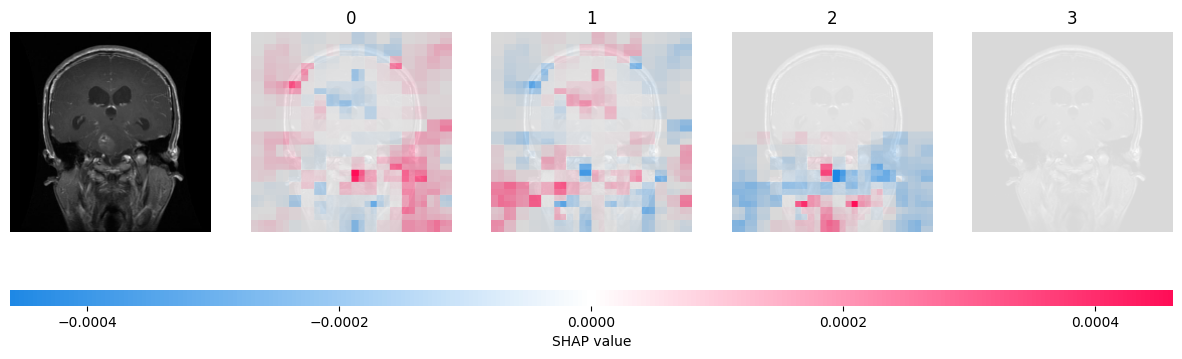

In [43]:
def f(x):
    tmp = x.copy()
    return model(tmp)
masker_blur = shap.maskers.Image("blur(200,200)", resized_images_train_np[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(4)))
ind=[123]
shap_values_ = explainer( resized_images_test_np[ind], max_evals=10000, batch_size=50 )
shap.image_plot(shap_values_,labels = ['glioma', 'meningioma', 'notumor', 'pituitary'])

In [70]:
i = 886
prediction_scores = model.predict(resized_images_test_np[i:i+1])
predicted_index = np.argmax(prediction_scores[0])

predicted_index


1/1 [==============================] - 0s 39ms/step


2

  0%|          | 0/1998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:13, 13.10s/it]               


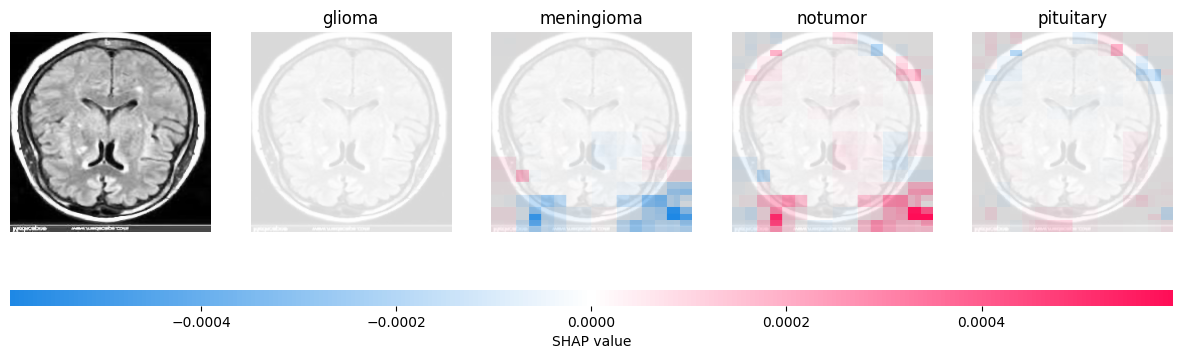

In [71]:
def f(x):
    tmp = x.copy()
    return model(tmp)
masker_blur = shap.maskers.Image("blur(200,200)", resized_images_train_np[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(4)))
ind=[886]
shap_values_ = explainer( resized_images_test_np[ind], max_evals=2000, batch_size=50 )
shap.image_plot(shap_values_,labels = ['glioma', 'meningioma', 'notumor', 'pituitary'])

In [72]:
i = 543
prediction_scores = model.predict(resized_images_test_np[i:i+1])
predicted_index = np.argmax(prediction_scores[0])

predicted_index


1/1 [==============================] - 0s 38ms/step


1

  0%|          | 0/1998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.98s/it]               


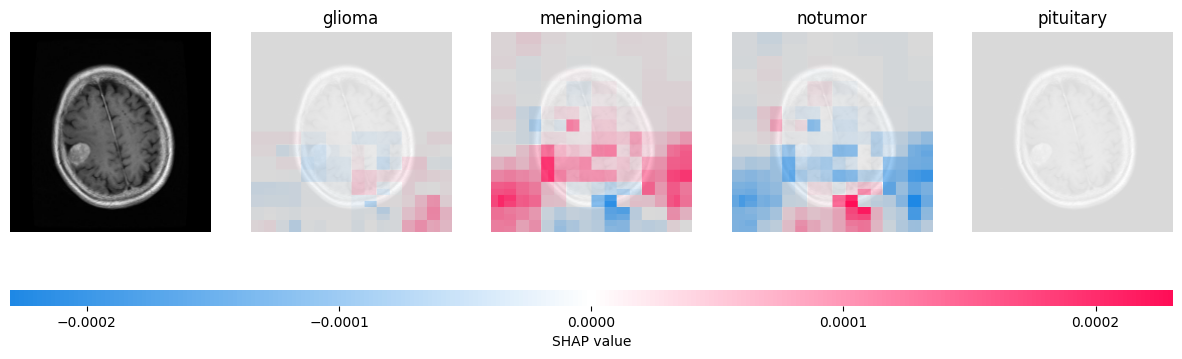

In [73]:
def f(x):
    tmp = x.copy()
    return model(tmp)
masker_blur = shap.maskers.Image("blur(200,200)", resized_images_train_np[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(4)))
ind=[543]
shap_values_ = explainer( resized_images_test_np[ind], max_evals=2000, batch_size=50 )
shap.image_plot(shap_values_,labels = ['glioma', 'meningioma', 'notumor', 'pituitary'])